<a href="https://colab.research.google.com/github/gnitnaw/Programs/blob/master/Chapter8/BaggingExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.13


# Example 8.3
## Import modules

In [2]:
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
print(np.__version__)

1.21.5


## Set random seed

In [3]:
np.random.seed(100)

## Original Program

In [4]:
# create regression problem
n_points = 1000 # points
x, y =  make_friedman1(n_samples=n_points, n_features=15, 
                       noise=1.0, random_state=100)

# split to train/test set
x_train, x_test, y_train, y_test = \
        train_test_split(x, y, test_size=0.33, random_state=100)

# training
regTree = DecisionTreeRegressor(random_state=100)
regTree.fit(x_train,y_train)

# test
yhat = regTree.predict(x_test)

# Bagging construction
n_estimators=500
bag = np.empty((n_estimators), dtype=object)
bootstrap_ds_arr = np.empty((n_estimators), dtype=object)
for i in range(n_estimators):
    # sample bootsraped dataset
    ids = np.random.choice(range(0,len(x_train)),size=len(x_train),
                     replace=True)
    x_boot = x_train[ids]
    y_boot = y_train[ids]
    bootstrap_ds_arr[i] = np.unique(ids)
    
    bag[i] = DecisionTreeRegressor()
    bag[i].fit(x_boot,y_boot)

# bagging prediction
yhatbag = np.zeros(len(y_test))   
for i in range(n_estimators): 
    yhatbag = yhatbag + bag[i].predict(x_test)
        
yhatbag = yhatbag/n_estimators

# out of bag loss estimation
oob_pred_arr = np.zeros(len(x_train))
for i in range(len(x_train)):
    x = x_train[i].reshape(1, -1)
    C = []
    for b in range(n_estimators):
        if(np.isin(i, bootstrap_ds_arr[b])==False):
            C.append(b)
    for pred in bag[C]:       
        oob_pred_arr[i] = oob_pred_arr[i] + (pred.predict(x)/len(C))        

L_oob = r2_score(y_train, oob_pred_arr)

print("DecisionTreeRegressor R^2 score = ",r2_score(y_test, yhat),  
      "\nBagging R^2 score = ", r2_score(y_test, yhatbag),
      "\nBagging OOB R^2 score = ",L_oob)

DecisionTreeRegressor R^2 score =  0.5652585102808715 
Bagging R^2 score =  0.8025977878086985 
Bagging OOB R^2 score =  0.821036694265204


## Compare loss of N-fold cross-validation and OOB

DecisionTreeRegressor MSE score =  6.202244006259345 
cross_validate loss =  -6.471535822741479 
Bagging OOB MSE score =  2.6122999738651593
[0.         3.2397416  2.9345546  2.79842193 2.72171483 2.66544337
 2.60347049 2.59598918 2.57506642 2.57268938 2.55989668 2.54428578
 2.5337913  2.53188089 2.52454532 2.52558294 2.51834868 2.50841033
 2.50840561 2.50573107]
[233.1027803   19.13089933   5.02534907   3.54055755   3.22514864
   3.07664348   2.95072715   2.88303106   2.84915297   2.8119519
   2.7759019    2.74073681   2.72145181   2.69947694   2.68673099
   2.67335831   2.6597098    2.64409293   2.63479198   2.62471476]
[  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
  95 100]


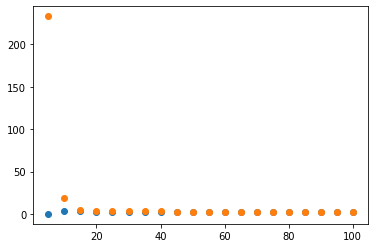

In [5]:
n = 10000
Bmax = 100
unitB = 5
X, Y =  make_friedman1(n_samples=n, n_features=15, noise=1.0, random_state=100)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=100)

# training
regTree = DecisionTreeRegressor(random_state=100)
regTree.fit(X_train,Y_train)

# test
yhat = regTree.predict(X_test)
DTMSE = mean_squared_error(Y_test, yhat)

clf = DecisionTreeRegressor()
cv_results = cross_val_score(clf, X_train, Y_train, cv=Y_train.shape[0], scoring ='neg_mean_squared_error')

error_B = np.zeros(int(Bmax/unitB))
OOB_B = np.zeros((int(Bmax/unitB),Y_train.shape[0]))
# Bagging construction
n_estimators=Bmax
bag = np.empty((n_estimators), dtype=object)
bootstrap_ds_arr = np.empty((n_estimators), dtype=object)
for i in range(n_estimators):
    # sample bootsraped dataset
    ids = np.random.choice(range(0,len(X_train)),size=len(X_train),
                     replace=True)
    
    x_boot = X_train[ids]
    y_boot = Y_train[ids]
    bootstrap_ds_arr[i] = np.unique(ids)
    bag[i] = DecisionTreeRegressor()
    bag[i].fit(x_boot,y_boot)

# bagging prediction
yhatbag = np.zeros(len(Y_test))   
for i in range(n_estimators): 
    yhatbag = yhatbag + bag[i].predict(X_test)
    if i > 0 and i%unitB ==0 :
        error_B[int(i/unitB)] = mean_squared_error(Y_test, yhatbag/(i+1))

# out of bag loss estimation
oob_pred_arr = np.zeros(len(X_train))
for i in range(len(X_train)):
    x = X_train[i].reshape(1, -1)
    C = []
    for b in range(n_estimators):
        if(np.isin(i, bootstrap_ds_arr[b])==False):
            C.append(b)
        if (b>0 and b%unitB ==0) :
            for pred in  bag[C]:       
                OOB_B[int(b/unitB)][i] = OOB_B[int(b/unitB)][i] + (pred.predict(x)/len(C))
    #print(len(C))
    for pred in  bag[C]:       
        oob_pred_arr[i] = oob_pred_arr[i] + (pred.predict(x)/len(C))

LL_oob = mean_squared_error(Y_train, oob_pred_arr)
OOB_difB = np.zeros(int(Bmax/unitB))

for i in range(int(Bmax/unitB)):
    OOB_difB[i] = mean_squared_error(Y_train, OOB_B[i])

print("DecisionTreeRegressor MSE score = ", DTMSE,  
      "\ncross_validate loss = ", np.mean(cv_results), 
      "\nBagging OOB MSE score = ",LL_oob)
print(error_B)
print(OOB_difB)
xx = (np.arange(int(Bmax/unitB))+1)*unitB
print(xx)
plt.scatter(xx, error_B)
plt.scatter(xx, OOB_difB)
plt.show()